In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
from scipy.fftpack import dct, idct, 
from skimage import data

plt.gray()
%matplotlib inline

In [75]:
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')
def gnoise(a, sig):
    return np.clip(a+sig*np.random.randn(*a.shape), a.min(), a.max())
def spnoise(a, p):
    n = np.random.rand(*a.shape)
    l = n<p/2
    u = n>(1-p/2)
    return a * ~(l|u) + u*a.max()
def low_pass(im, n_pass, tr=None):
    if tr is None:
        tr = dct2(im)
    m = np.zeros_like(im)
    x, y=np.mgrid[:im.shape[0], :im.shape[1]]
    d = np.sqrt(x**2 + y**2)
    m[d<n_pass] = 1
    return idct2(tr*m)
def high_pass(im, n_pass, tr=None):
    if tr is None:
        tr = dct2(im)
    m = np.zeros_like(im)
    m[-n_pass:, -n_pass:] = 1
    return idct2(tr*m)
def band_pass(im, bounds):
    lb, ub = bounds # bounds= ((i,j), (k,l))
    tr = dct2(im)
    m = np.zeros_like(im)
    m[lb[0]:ub[0], lb[1]:ub[1]] = 1
    return idct2(tr*m)
def arb_pass(im, mask):
    return idct2(dct2(im)*mask)

In [70]:
im = data.camera() / 255.0

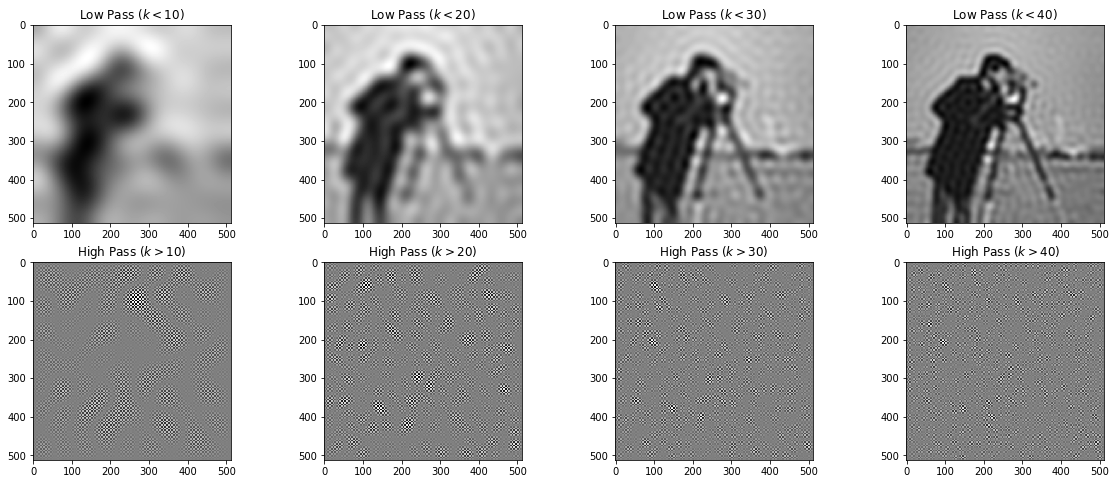

In [76]:
plt.figure(figsize=(20, 8))
for i in range(1, 5):
    ax = plt.subplot(2, 4, i)
    ax.imshow(low_pass(im, 10*i))
    ax.set_title('Low Pass ($k < %d$)'% (10*i))
for i in range(1, 5):
    ax = plt.subplot(2, 4, i+4)
    ax.imshow(high_pass(im, 10*i))
    ax.set_title('High Pass ($k > %d$)'% (10*i))

In [71]:
errs = []
tr = dct2(im)
for i in range(im.shape[1]+1):
    errs.append(np.sqrt(((low_pass(im, i, tr) - im)**2).mean()))

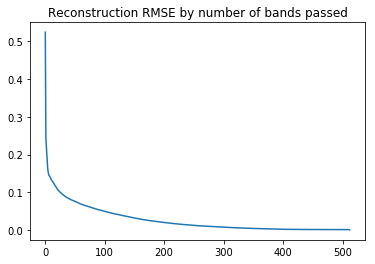

In [72]:
plt.title('Reconstruction RMSE by number of low bands passed')
plt.plot(errs)